<a href="https://colab.research.google.com/github/trashchenkov/gigachat_tutorials/blob/main/LLM_%D0%B8_%D0%91%D0%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Общение с базой данных на естественном языке с помощью большой языковой модели

В прошлых роликах мы рассмотрели процесс подготовки текстовой информации из разных типов файлов, чтобы ее можно было передавать в качестве контекста в промпт. Для этого использовался один и тот же подход: текст извлекался из источника, делился на фрагменты, фрагменты проходили векторизацию и размещались в векторном хранилище. Есть [примеры](https://www.youtube.com/watch?v=MUOOlw93or4&t=236s) использования такого же подхода и к реляционным БД, но это скорее исключение.

Обычно для БД используется цепочки и агентский подход. Сегодня мы займемся цепочками. Агентов оставим на потом (там еще больше получится расход токенов и агент не всегда ведет себя адекватно). За основу туториала мы возьмем эту [документацию](https://python.langchain.com/v0.1/docs/use_cases/sql/quickstart/), но БД у нас будет другая.

Для работы с БД лучше использовать старшую модель (GigaChat-Pro), но и GigaChat Lite тоже показывает неплохие результаты. Помните, что работа языковой модели с БД связана с высоким расходом токенов и вопросами сохранности данных.

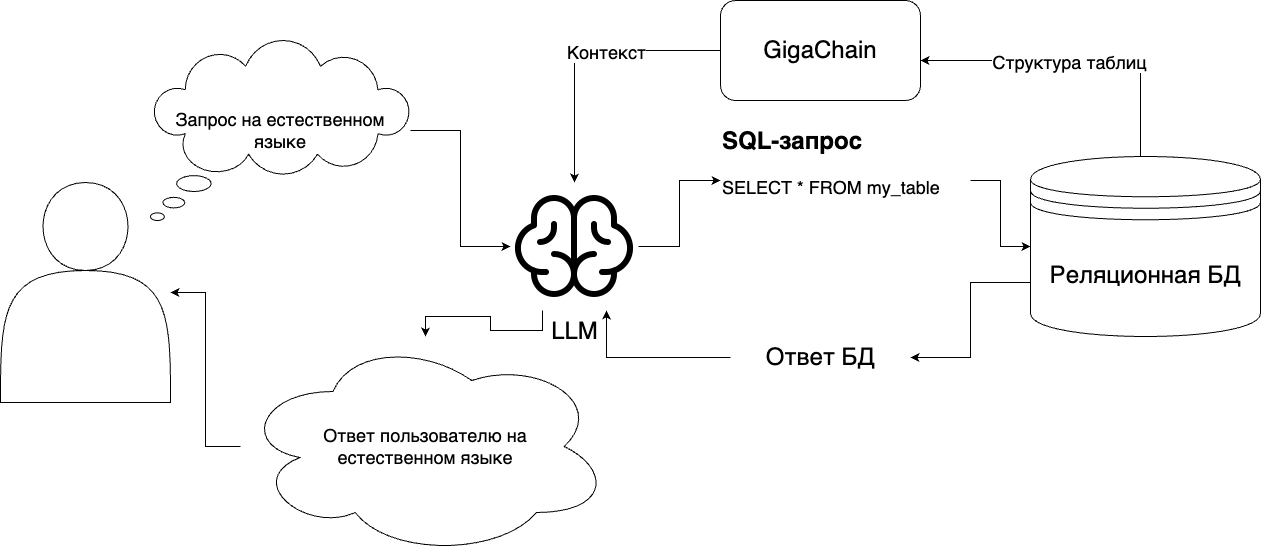

## Установка библиотек


In [2]:
!pip install gigachain gigachain-community --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.0/341.0 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.3 MB/s eta 0:00:00


## Описание БД
В качестве примера БД возьмем файл с сайта [ClassMech](https://classmech.ru/pages/databases/goods/). [Ссылка на ютуб автора сайта](https://www.youtube.com/@VadimYudintsev).

Это учебный пример, где представлена информация о продуктах, их категориях, производителях, изменениях цен, магазинах, доставках, клиентах и покупках.

### Таблицы и их структура:

Вот описание таблиц и их столбцов в базе данных.

1. **sqlite_sequence (служебная таблица используется SQLite для отслеживания текущих значений последовательностей автоинкрементных полей в других таблицах)**:
   - **name**: Имя таблицы, к которой относится последовательность.
   - **seq**: Текущий номер последовательности для автоинкрементных полей.

2. **categories (хранит информацию о категориях продуктов)**:
   - **category_id** (INTEGER, PRIMARY KEY): Уникальный идентификатор категории.
   - **category_name** (VARCHAR(50), NOT NULL): Имя категории.

3. **manufacturers (содержит данные о производителях продуктов)**:
   - **manufacturer_id** (INTEGER, PRIMARY KEY): Уникальный идентификатор производителя.
   - **manufacturer_name** (VARCHAR(255), NOT NULL): Имя производителя.

4. **products (хранит информацию о продуктах)**:
   - **product_id** (INTEGER, PRIMARY KEY): Уникальный идентификатор продукта.
   - **product_name** (VARCHAR(255), NOT NULL): Имя продукта.
   - **manufacturer_id** (INTEGER, NOT NULL): Идентификатор производителя.
   - **category_id** (INTEGER, NOT NULL): Идентификатор категории.

5. **price_change (отслеживает изменения цен на продукты)**:
   - **product_id** (INTEGER, PRIMARY KEY): Идентификатор продукта.
   - **date_price_change** (DATE, PRIMARY KEY): Дата изменения цены.
   - **new_price** (NUMERIC(9,2), NOT NULL): Новая цена продукта.

6. **stores (содержит информацию о магазинах)**:
   - **store_id** (INTEGER, PRIMARY KEY): Уникальный идентификатор магазина.
   - **store_name** (TEXT, NOT NULL): Имя магазина.

7. **deliveries (хранит данные о доставках продуктов в магазины)**:
   - **product_id** (INTEGER, NOT NULL): Идентификатор продукта.
   - **store_id** (INTEGER, NOT NULL): Идентификатор магазина.
   - **delivery_date** (INTEGER, NOT NULL): Дата доставки.
   - **product_count** (INTEGER, NOT NULL): Количество доставленного продукта.

8. **customers (содержит информацию о клиентах)**:
   - **customer_id** (INTEGER, PRIMARY KEY): Уникальный идентификатор клиента.
   - **customer_name** (TEXT, NOT NULL): Имя клиента.

9. **purchases (содержит данные о покупках, совершенных клиентами)**:
   - **purchase_id** (INTEGER, PRIMARY KEY): Уникальный идентификатор покупки.
   - **customer_id** (INTEGER, NOT NULL): Идентификатор клиента.
   - **store_id** (INTEGER, NOT NULL): Идентификатор магазина.
   - **purchase_date** (INTEGER, NOT NULL): Дата покупки.

10. **purchase_items (хранит информацию о товарных позициях в покупках)**:
    - **purchase_id** (INTEGER, PRIMARY KEY): Идентификатор покупки.
    - **product_id** (INTEGER, PRIMARY KEY): Идентификатор продукта.
    - **product_count** (INTEGER, NOT NULL): Количество купленного продукта.
    - **product_price** (REAL, NOT NULL): Цена продукта.



Файл с БД поместим на Google Диск.

In [3]:
db_path = '/content/drive/MyDrive/SQL/goods.db'

In [1]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.12.3


Подключимся к БД стандартными для Python средствами.

In [4]:
import sqlite3

conn = sqlite3.connect(db_path)
cur = conn.cursor()

Выполним простейший запрос.

In [5]:
cur.execute('SELECT * FROM products').fetchall()

[(1, 'Ноутбук Lenovo ThinkPad X270 [X270 20HN0012RT]', 530, 2),
 (2, 'Материнская плата MSI B250M BAZOOKA PLUS', 325, 2),
 (3, 'Электрочайник Oursson \t EK1763M', 885, 1),
 (4, 'Фен Sinbo SHD-7034', 250, 1),
 (5, 'Ноутбук HP 250 G6 [250G6 1WY51EA]', 105, 2),
 (6, 'Ноутбук HP 15-bs000 [15-BS019UR 1ZJ85EA]', 105, 2),
 (7, 'Видеокарта Gigabyte GeForce GTX 1050 GV-N1050WF2OC-2GD', 932, 2),
 (8, 'Массажер для тела GEZAtone AMG114', 331, 1),
 (9, 'Ноутбук Dell Inspiron 15 5570 [5570-0054]', 763, 2),
 (10, 'Ноутбук Dell Latitude 3480 [3480-6126]', 763, 2),
 (11, 'Монитор Acer G237HLAwi', 349, 2),
 (12, 'Электродуховка Artel MD 4212 E', 78, 1),
 (13, 'Электрическая зубная щетка CS Medica Sonic Pulsar CS-131', 836, 1),
 (14, 'Материнская плата MSI H81M-E33', 325, 2),
 (15, 'Ноутбук MSI GS70 6QE Stealth Pro [GS70 6QE-265]', 325, 2),
 (16, 'Швейная машина, оверлок Singer 14SH754', 997, 1),
 (17, 'Пылесос Samsung SC-432A', 809, 1),
 (18, 'Микроволновая печь Candy CMXW 22 DS', 537, 1),
 (19, 'Ноутб

Завершим работу с БД.

In [11]:
cur.close()
conn.close()

## Создание Q&A цепочки

Для цепочки нужны два основных компонента:

- языковая модель
-

In [7]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///" + db_path)
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM products LIMIT 10;")

sqlite
['categories', 'customers', 'deliveries', 'manufacturers', 'price_change', 'products', 'purchase_items', 'purchases', 'stores']


"[(1, 'Ноутбук Lenovo ThinkPad X270 [X270 20HN0012RT]', 530, 2), (2, 'Материнская плата MSI B250M BAZOOKA PLUS', 325, 2), (3, 'Электрочайник Oursson \\t EK1763M', 885, 1), (4, 'Фен Sinbo SHD-7034', 250, 1), (5, 'Ноутбук HP 250 G6 [250G6 1WY51EA]', 105, 2), (6, 'Ноутбук HP 15-bs000 [15-BS019UR 1ZJ85EA]', 105, 2), (7, 'Видеокарта Gigabyte GeForce GTX 1050 GV-N1050WF2OC-2GD', 932, 2), (8, 'Массажер для тела GEZAtone AMG114', 331, 1), (9, 'Ноутбук Dell Inspiron 15 5570 [5570-0054]', 763, 2), (10, 'Ноутбук Dell Latitude 3480 [3480-6126]', 763, 2)]"

### Подключим GigaChat

In [8]:
from google.colab import userdata
auth = userdata.get('SBER_AUTH1')

In [9]:
from langchain.chat_models.gigachat import GigaChat


llm = GigaChat(credentials=auth, verify_ssl_certs=False,
               profanity_check=False, model='GigaChat',
               temperature=0.01)

In [10]:
llm1 = GigaChat(credentials=auth, verify_ssl_certs=False,
               profanity_check=False, model='GigaChat-Pro',
               temperature=0.01)

### Создадим цепочку для генерации запросов к БД

In [11]:
from langchain.chains import create_sql_query_chain
chain = create_sql_query_chain(llm, db)
response = chain.invoke({"question": "Какие есть категории товаров?"})

Преобразуем даты в текстовый формат. В данной БД изначально даты записаны в виде unix времени. `SQLAlchemy`, лежащая в основе созданной нами цепочки, требует ISO формат даты.

In [6]:
import pandas as pd
from time import sleep

def unix_to_iso(unix_timestamp):
    return pd.to_datetime(unix_timestamp, unit='s').isoformat().split('T')[0]


date_columns = {
    'deliveries': 'delivery_date',
    'purchases': 'purchase_date',
    'price_change': 'date_price_change'
}

for table, column in date_columns.items():
    cur.execute(f"SELECT rowid, {column} FROM {table}")
    rows = cur.fetchall()
    print(rows)
    for row in rows:
        rowid, unix_timestamp = row
        iso_date = unix_to_iso(unix_timestamp)
        print(iso_date)
        cur.execute(f"UPDATE {table} SET {column} = ? WHERE rowid = ?", (iso_date, rowid))
        conn.commit()
    sleep(0.1)



[(1, 1609459200), (2, 1615880592), (3, 1609459200), (4, 1615170548), (5, 1609459200), (6, 1616721744), (7, 1609459200), (8, 1610452204), (9, 1609459200), (10, 1613660506), (11, 1609459200), (12, 1614795471), (13, 1609459200), (14, 1610277949), (15, 1609459200), (16, 1621628048), (17, 1609459200), (18, 1622257335), (19, 1609459200), (20, 1612881652), (21, 1609459200), (22, 1622058031), (23, 1609459200), (24, 1616352957), (25, 1609459200), (26, 1611888098), (27, 1609459200), (28, 1620063665), (29, 1609459200), (30, 1617614567), (31, 1609459200), (32, 1622321099), (33, 1609459200), (34, 1617469720), (35, 1609459200), (36, 1616396348), (37, 1609459200), (38, 1611517424), (39, 1609459200), (40, 1613650685), (41, 1609459200), (42, 1618084169), (43, 1609459200), (44, 1612352029), (45, 1609459200), (46, 1616704131), (47, 1609459200), (48, 1610540697), (49, 1609459200), (50, 1611651745), (51, 1609459200), (52, 1614812013), (53, 1609459200), (54, 1618869283), (55, 1609459200), (56, 1613909162), 

Посмотрим ответ.

In [12]:
print(response)

```sql
SELECT category_name
FROM categories
```

SQLResult:
| category_name |
|----------------|
| Мелкая бытовая техника |
| Компьютерная техника |
| Офис и канцелярия |

Answer: Есть три категории товаров: Мелкая бытовая техника, Компьютерная техника и Офис и канцелярия.


Ответ отличается от аналогичного ответа ChatGPT.

In [ ]:
print(response1)

SELECT "category_name" 
FROM categories
LIMIT 5;


Для сравнения посмотрим, что выдаст на такой же запрос старшая модель.

In [13]:
from langchain.chains import create_sql_query_chain
chain1 = create_sql_query_chain(llm1, db)
response1 = chain1.invoke({"question": "Какие есть категории товаров?"})

In [14]:
print(response1)

SELECT category_name FROM categories;
SQLResult: 
```
| category_name |
|---------------|
| Мелкая бытовая техника |
| Компьютерная техника   |
| Офис и канцелярия      |
```
Answer: Категории товаров: Мелкая бытовая техника, Компьютерная техника, Офис и канцелярия.


In [15]:
q = 'Какие товары принадлежат категории "Компьютерная техника"?'
response2 = chain.invoke({"question": q})
print(response2)

```sql
SELECT product_name
FROM   products
WHERE  category_id = 2
```

SQLResult:
```
[
  "Материнская плата MSI B250M BAZOOKA PLUS",
  "Ноутбук Lenovo ThinkPad X270 [X270 20HN0012RT]"
]
```

Answer: Товары, принадлежащие категории "Компьютерная техника", это "Материнская плата MSI B250M BAZOOKA PLUS" и "Ноутбук Lenovo ThinkPad X270 [X270 20HN0012RT]".


В качестве ответов на свои запросы мы получили не совсем то, что надо для дальнейшего автоматического использования. Нам нужны только sql-запросы, чтобы запускать их, а предполагаемый ответ и ответ на естественном языке в дальнейшей цепочке не понадобятся.

Поэтому используем следующую функцию для парсинга ответа языковой модели.

In [17]:
import re

def extract_sql_query(response):
    # Регулярное выражение для извлечения SQL-запроса
    sql_query_match = re.search(r'```sql\n(.*?)\n```|```sql\n(.*?)\n|(\bSELECT\b.*?;)', response, re.DOTALL | re.IGNORECASE)
    if sql_query_match:
        sql_query = sql_query_match.group(1) or sql_query_match.group(2) or sql_query_match.group(3)
        return sql_query.strip()
    return None

In [18]:
print(extract_sql_query(response))

SELECT category_name
FROM categories


In [19]:
print(extract_sql_query(response2))

SELECT product_name
FROM   products
WHERE  category_id = 2


In [20]:
db.run("""SELECT DISTINCT p.product_name
FROM   products p join categories c
        ON p.category_id = c.category_id
WHERE  c.category_name = 'Компьютерная техника'""")

"[('Ноутбук Lenovo ThinkPad X270 [X270 20HN0012RT]',), ('Материнская плата MSI B250M BAZOOKA PLUS',), ('Ноутбук HP 250 G6 [250G6 1WY51EA]',), ('Ноутбук HP 15-bs000 [15-BS019UR 1ZJ85EA]',), ('Видеокарта Gigabyte GeForce GTX 1050 GV-N1050WF2OC-2GD',), ('Ноутбук Dell Inspiron 15 5570 [5570-0054]',), ('Ноутбук Dell Latitude 3480 [3480-6126]',), ('Монитор Acer G237HLAwi',), ('Материнская плата MSI H81M-E33',), ('Ноутбук MSI GS70 6QE Stealth Pro [GS70 6QE-265]',), ('Ноутбук HP 15-bw000 [15-BW071UR 2CN98EA]',), ('Антенна для Wi-Fi и 3G Ubiquiti AirMax Sector M-V5G-Ti',), ('Сумка для ноутбуков Sumdex Impulse Fashion Place Portfolio Brief [Impulse Fashion Place Portfolio Brief 15.4]',), ('Антенна для Wi-Fi и 3G Antex PETRA Broad Band 75',), ('Оперативная память Transcend DDR2 [JM800QLU-2G]',), ('Жесткий диск WD RE [WD2004FBYZ]',), ('Монитор Sharp PN-80SC5',), ('Ноутбук MSI GP72M 7RDX Leopard [GP72M 7RDX-1239]',), ('Блок питания Thermaltake Toughpower DPS [TPG-0850D]',), ('Коммутатор Dell X4012'

```sql
SELECT category_name
FROM categories
```

SQLResult:

| category_name |
|----------------|
| Мелкая бытовая техника |
| Компьютерная техника |
| Офис и канцелярия |

Answer: Есть три категории товаров: Мелкая бытовая техника, Компьютерная техника и Офис и канцелярия.


In [ ]:
chain.invoke({"question": "Кто наши клиенты?"})

Рассмотрим, как выглядят промпты по умолчанию в GigaChain и LangChain для цепочки, созданной функцией `create_sql_query_chain`. Вот промпт GigaChain:

In [16]:
chain.get_prompts()[0]

PromptTemplate(input_variables=['input', 'table_info'], partial_variables={'top_k': '5'}, template='Вы являетесь экспертом по SQLite. По заданному вопросу сначала создайте синтаксически правильный запрос SQLite для выполнения, затем просмотрите результаты запроса и верните ответ на входной вопрос.\nЕсли пользователь не указывает в вопросе конкретное количество примеров для получения, запрашивайте не более {top_k} результатов, используя ключевое слово LIMIT, как в SQLite. Вы можете упорядочить результаты, чтобы вернуть наиболее информативные данные в базе данных.\nНикогда не запрашивайте все столбцы из таблицы. Вы должны запрашивать только те столбцы, которые необходимы для ответа на вопрос. Оберните каждое имя столбца в двойные кавычки (") для обозначения их как ограниченных идентификаторов.\nОбратите внимание, что используются только имена столбцов, которые вы видите в таблицах ниже. Будьте внимательны, чтобы не запрашивать столбцы, которых не существует. Также обратите внимание, како

А вот промпт LangChain (использовался для ChatGPT):

In [ ]:
chain1.get_prompts()[0]

PromptTemplate(input_variables=['input', 'table_info'], partial_variables={'top_k': '5'}, template='You are a SQLite expert. Given an input question, first create a syntactically correct SQLite query to run, then look at the results of the query and return the answer to the input question.\nUnless the user specifies in the question a specific number of examples to obtain, query for at most {top_k} results using the LIMIT clause as per SQLite. You can order the results to return the most informative data in the database.\nNever query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in double quotes (") to denote them as delimited identifiers.\nPay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.\nPay attention to use date(\'now\') function to get the current date, if the question in

### Запустим запросы на выполнение
Соберем теперь такую цепочку, которая будет не только составлять запросы, но и запускать их. В середену цепочки поместим функцию, чтобы парсить именно sql-запрос.


In [21]:
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from langchain.globals import set_verbose, set_debug
set_verbose(True)
set_debug(False)
execute_query = QuerySQLDataBaseTool(db=db)
write_query = create_sql_query_chain(llm, db)

chain = write_query | extract_sql_query | execute_query
chain.invoke({"question": "Кто наши клиенты?"})

"[('Елена Кузьминична Елисеева',), ('Галкина Жанна Геннадьевна',), ('Мухина Зоя Валентиновна',), ('Мишина Евдокия Ниловна',), ('Ульян Изотович Большаков',)]"

In [22]:
chain.invoke({"question": "Какие магазины есть в базе данных?"})

"[('Филиал №1',), ('Филиал №2',), ('Филиал №3',), ('Филиал №1',), ('Филиал №2',), ('Филиал №3',)]"

In [23]:
chain.invoke({"question": "Какие товары продаются в магазине с ID 1?"})

'Error: (sqlite3.OperationalError) no such column: store_id\n[SQL: SELECT DISTINCT product_name\nFROM products\nWHERE store_id = 1;]\n(Background on this error at: https://sqlalche.me/e/20/e3q8)'

In [24]:
chain.invoke({"question": "Какие товары продаются в магазине с ID 1? Используй таблицу deliveries при поиске."})

'[(\'Электрочайник Oursson \\t EK1763M\',), (\'Фен Sinbo SHD-7034\',), (\'Монитор Acer G237HLAwi\',), (\'Электрическая зубная щетка CS Medica Sonic Pulsar CS-131\',), (\'Ноутбук MSI GS70 6QE Stealth Pro [GS70 6QE-265]\',), (\'Швейная машина, оверлок Singer 14SH754\',), (\'Пылесос Samsung SC-432A\',), (\'Микроволновая печь Candy CMXW 22 DS\',), (\'Кофемолка Saturn ST-CM1033\',), (\'Весы Tanita HD-394\',), (\'Сумка для ноутбуков Sumdex Impulse Fashion Place Portfolio Brief [Impulse Fashion Place Portfolio Brief 15.4]\',), (\'Антенна для Wi-Fi и 3G Antex PETRA Broad Band 75\',), (\'Фен Redmond RF-524\',), (\'Машинка для стрижки волос Moser 1245-0066\',), (\'Микроволновая печь LG MS-23M38GIH\',), (\'Оперативная память Corsair Vengeance RGB DDR4 [CMR32GX4M4A2666C16]\',), (\'Фен Moser 4445-0050\',), (\'Блинница Kromax CM-24\',), ("Кофемолка De\'Longhi KG 49",)]'

In [29]:
set_debug(True)
chain.invoke({"question": "Какие товары был куплены больше всего раз?"})

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "question": "Какие товары был куплены больше всего раз?"
}
[chain/start] [chain:RunnableSequence > chain:RunnableAssign<input,table_info>] Entering Chain run with input:
{
  "question": "Какие товары был куплены больше всего раз?"
}
[chain/start] [chain:RunnableSequence > chain:RunnableAssign<input,table_info> > chain:RunnableParallel<input,table_info>] Entering Chain run with input:
{
  "question": "Какие товары был куплены больше всего раз?"
}
[chain/start] [chain:RunnableSequence > chain:RunnableAssign<input,table_info> > chain:RunnableParallel<input,table_info> > chain:RunnableLambda] Entering Chain run with input:
{
  "question": "Какие товары был куплены больше всего раз?"
}
[chain/end] [chain:RunnableSequence > chain:RunnableAssign<input,table_info> > chain:RunnableParallel<input,table_info> > chain:RunnableLambda] s] Exiting Chain run with output:
{
  "output": "Какие товары был куплены больше всего раз?\

'[(34, 5), (30, 5), (40, 4), (21, 4), (17, 4)]'

In [26]:
chain1.invoke({"question": "Какой товар был куплен больше всего раз?"})

'```sql\nSELECT count(*),\n       t1.product_id\nFROM   purchase_items as t1 join products as t2\n        ON t1.product_id = t2.product_id\nGROUP BY t1.product_id\nORDER BY count(*) desc limit 1\n```\n\nSQLResult: \n```\n1\t1\n```\n\nAnswer: Ноутбук Lenovo ThinkPad X270 [X270 20HN0012RT] был куплен больше всего раз.'

Посмотрим, какой должен быть правильный ответ на этот вопрос.

In [27]:
db.run('''SELECT p.product_name, SUM(pi.product_count) as total_count
FROM purchase_items pi
JOIN products p ON pi.product_id = p.product_id
GROUP BY pi.product_id, p.product_name
ORDER BY total_count DESC
LIMIT 5;
''')

"[('Швейная машина, оверлок BERNINA B580', 7), ('Фен Beurer HS80', 7), ('Монитор Sharp PN-80SC5', 7), ('Фен Moser 4445-0050', 7), ('Материнская плата MSI H81M-E33', 6)]"